In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import simps
import os
import glob
from scipy.optimize import minimize  

In [2]:
def load_csv(name):
    '''
    parameter:
    name --> csv file name
    
    output:
    test --> original csv file, with date and expiration column convert to pd datetime format
    df --> dataframe with dates as index and [rf, spx and all the possible strike prices] as column
    '''
    test = pd.read_csv(name)
    test['Date'] = pd.to_datetime(test['Date'])
    test['Expiration'] = pd.to_datetime(test['Expiration'])
    
    df = yf.download(['^SPX', '^IRX'],start = test.iloc[0, 0],end = test.iloc[-1, 0] + pd.Timedelta(days=1))['Adj Close']
    for i in range(1500):
        df = df.copy()
        df.loc[:,f'{i*5+100}'] = 0
    df = df.rename(columns={'^IRX': 'rf', '^SPX': 'Close'})
    if pd.to_datetime('2016-10-10') in df.index:
        df.loc[pd.to_datetime('2016-10-10'), 'rf'] = 0.32
    elif pd.to_datetime('2016-11-11') in df.index:
        df.loc[pd.to_datetime('2016-11-11'), 'rf'] = 0.46
    return test, df


In [3]:
def date_strike(test, df):
    '''
    parameters:
    test --> original csv file
    df --> dataframe with datetime as index and strike as columns (all zeros entries)
    
    output:
    df --> dataframe with datetime as index and strike as columns (mapping original csv data into this table, including put-call concerns)
    '''
    
    for i in range(len(test)):
        if test['Date'][i] in df.index:
            if test['Volume'][i] == 0:
                continue
            else:
                if df.loc[f"{test['Date'][i]}", f"{test['Strike'][i]}"] != 0:
                    if df.loc[f"{test['Date'][i]}", f"{test['Strike'][i]}"] <= df.loc[f"{test['Date'][i]}", 'Close'] and test['CallPut'][i] == 'P':

                        price = test['Bestoffer'][i] + df.loc[f"{test['Date'][i]}", "Close"] - test['Strike'][i] * np.exp(-df.loc[f"{test['Date'][i]}", 'rf']/100 * (test['Expiration'][i] - test['Date'][i]).days/365)
                        price = round(price, 1)
                        if price < 0:
                            continue
                        else:
                            df.loc[f"{test['Date'][i]}", f"{test['Strike'][i]}"] = price
                    elif df.loc[f"{test['Date'][i]}", f"{test['Strike'][i]}"] >= df.loc[f"{test['Date'][i]}", 'Close'] and test['CallPut'][i] == 'C':
                        price = test['Bestoffer'][i]
                        df.loc[f"{test['Date'][i]}", f"{test['Strike'][i]}"] = price
                    else:
                        continue

                else:
                    if test['CallPut'][i] == 'P':
                        price = test['Bestoffer'][i] + df.loc[f"{test['Date'][i]}", "Close"] - test['Strike'][i] * np.exp(-df.loc[f"{test['Date'][i]}", 'rf']/100 * (test['Expiration'][i] - test['Date'][i]).days/365)
                        price = round(price, 1)
                        if price < 0:
                            continue
                        else:
                            df.loc[f"{test['Date'][i]}", f"{test['Strike'][i]}"] = price
                    else:
                        price = test['Bestoffer'][i]
                        df.loc[f"{test['Date'][i]}", f"{test['Strike'][i]}"] = price
    
    zero_cols = [col for col in df.columns if df[col].sum() == 0]
    df.drop(columns=zero_cols, inplace=True)

    return df
                    
            
            
            

In [4]:
def get_nwindow(df, n):
    '''
    parameters:
    df --> dataframe with datetime as index and strike as columns (with option price data)
    n --> number of window, paper used 5, adjustable, notice if use five-day window, n should be 4
    
    output:
    df_nday --> dataframe with datetime as index and strike as columns (with option price data adjusted for nday-window)
    
    '''
    
    df_nday = df.copy()
    for i in range(len(df_nday)-n):
        for j in range(df_nday.shape[1]-2):

            if df_nday.iloc[i+n, j+2] == 0:  
                for z in range(1,n):
                    if df.iloc[i+n-z, j+2] != 0:
                        df_nday.iloc[i+n, j+2] = df.iloc[i+n-z, j+2]
                        break
    return df_nday



In [5]:
def black_scholes(S, K, T, r, sigma):
    # Black-Scholes formula 
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def newton_implied_vol(S, K, T, r, C):
    MAX_ITERATIONS = 100
    PRECISION = 0.0001
    
    sigma = 0.5 # Initial volatility guess
    
    for i in range(MAX_ITERATIONS):
        price = black_scholes(S, K, T, r, sigma) 
        diff = price - C

        # Newton update step
        sigma -= diff / vega(S, K, T, r, sigma)
        
        # Check for convergence
        if abs(diff) < PRECISION:
            return sigma
        
    return sigma

def implied_vol(S, K, T, r, C):
    MAX_ITERATIONS = 100
    PRECISION = 0.0001
    
    sigma = 0.5 # Initial volatility guess
    
    for i in range(MAX_ITERATIONS):
        price = black_scholes(S, K, T, r, sigma) 
        diff = price - C

        # Newton update step
        sigma -= diff / 100
        
        # Check for convergence
        if abs(diff) < PRECISION:
            return sigma
        
    return sigma
    
def vega(S, K, T, r, sigma):
    # Vega formula
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T)) 
    return S * norm.pdf(d1) * np.sqrt(T)

imp_vol = newton_implied_vol(100, 105, 1, 0.05, 5) 

In [6]:
def get_iv(df_nday, test, n):
    '''
    parameters:
    df_nday --> dataframe with datetime as index and strike as columns (with option price data adjusted for nday-window)
    test --> original csv file
    n --> number of window, paper used 5, adjustable
    
    output；
    df_iv --> dataframe with datetime as index and strike as columns (entries are implied volatility based on option prices)
    '''
    df_iv = df_nday.copy()
    for i in range(len(df_iv)-n):
        for j in range(df_iv.shape[1]-2):
            if df_iv.iloc[i+n, j+2] != 0:
                iv = newton_implied_vol(df_nday.iloc[i+n, 1], int(df_iv.columns[j+2]), (test['Expiration'][i+n] - test['Date'][i+n]).days/365, df_nday.iloc[i+n, 0]/100, df_nday.iloc[i+n, j+2])
                if np.isnan(iv):
                    iv = implied_vol(df_nday.iloc[i+n, 1], int(df_iv.columns[j+2]), (test['Expiration'][i+n] - test['Date'][i+n]).days/365, df_nday.iloc[i+n, 0]/100, df_nday.iloc[i+n, j+2])
                df_iv.iloc[i+n, j+2] = round(iv, 4)
    return df_iv

In [7]:
def obj_func(params, x, y):
    pred_vols = params[0] * x + params[1] * np.sqrt(x) + params[2]
    errors = abs(pred_vols - y)
    return np.sum(errors)

In [8]:
def get_prob(df_iv, test, n, pct):
    '''
    parameters:
    df_iv --> dataframe with datetime as index and strike as columns (entries are implied volatility based on option prices)
    test --> original csv file
    n --> number of window, paper used 5, adjustable
    pct --> after 6M the up pct and down pct for sp500, paper used 20%, adjustable
    
    output:
    result --> dataframe with datetime as index and [rf, sp500 closes, up_prob, down_prob, skewness and kurtosis] as columns
    '''
    #create a new dataframe to hold generated probs and characteristics
    result = yf.download(['^SPX', '^IRX'],start = df_iv.iloc[n].name, end = df_iv.iloc[-1].name + pd.Timedelta(days=1))['Adj Close']
    result.loc[:,['up_prob', 'down_prob', 'skewness', 'kurtosis', 'mean', 'variance', 'median', 'p10', 'p90']] = 0

    for i in range(len(df_iv)-n):
        if len(df_iv) - n != len(result):
            print("size does not match")
            print(len(df_iv))
            print(df_iv.iloc[n].name)
            print(df_iv.iloc[-1].name)
            print(len(result))
            print(result.iloc[0].name)
            print(result.iloc[-1].name)
            break

        # filter out abnormal ivs with iv<0 and >2
        temp = df_iv.iloc[i + n, 2:]
        temp = temp.drop(temp[(temp <= 0)| (temp >= 2)].index)

        ''' can use IQR to filter out outlier or just simply filter out the first two and last two
        q1 = temp.quantile(0.25)
        q3 = temp.quantile(0.75) 
        iqr = q3 - q1
        upper = q3 + 3 * iqr
        lower = q1 - 3 * iqr 
        temp = temp[(temp > lower) & (temp < upper)]

        '''
        #temp = temp[1:]

        # x will be strikes and y will be ivs
        x = np.array([int(str) for str in temp.index])
        y = np.array(temp)
        
        '''
        spl = UnivariateSpline(x, y, k = 2)

        # Predict smooth values
        xs = np.arange(min(x)-min(x), max(x)+min(x), 1)
        ys = np.maximum(spl(xs), 0)
        '''
        # optimizations with polinomial and constraints
        beta0 = [0.00001, 0.001, 0.1] 
        cons = ({'type':'ineq', 'fun': lambda beta: beta[0]})
        res = minimize(obj_func, beta0, args=(x, y), method='SLSQP', constraints = cons)
        a_opt, b_opt, c_opt= res.x

        # extend the up and down to +- 50% compared to current close
        if int(df_iv.iloc[i+n, 1]*0.5) > min(x):
            down_extend = 0
        else:
            down_extend = min(x) - int(df_iv.iloc[i+n, 1]*0.5)

        if int(df_iv.iloc[i+n, 1]*1.5) > max(x):
            up_extend = int(df_iv.iloc[i+n, 1]*1.5) - max(x)
        else:
            up_extend = 0
            
        xs = np.arange(min(x) - down_extend, max(x) + up_extend, 1)
        ys = np.array([np.maximum(a_opt * strike + b_opt * np.sqrt(strike) + c_opt , 0) for strike in xs])

        #generate callprice wrt strikes based on smoothed iv curve
        callprice = []
        for z in range(len(xs)):
            callprice.append(black_scholes(df_iv.iloc[i+n, 1], xs[z], (csvfile['Expiration'][i+n] - csvfile['Date'][i+n]).days/365, df_iv.iloc[i+n, 0]/100, ys[z]))

        # take second derivative
        dy = np.gradient(callprice)
        d2y = np.maximum(np.gradient(dy),0)
        d2y = d2y * np.exp(-(csvfile['Expiration'][i+n] - csvfile['Date'][i+n]).days/365 * df_iv.iloc[i+n, 0]/100)
        
        # integration
        downdiff = int(df_iv.iloc[i+n, 1] * (1-pct)) - (min(x)-down_extend) + 1
        xaxis = np.arange(min(x)-down_extend, int(df_iv.iloc[i+n, 1] * (1-pct))+1)
        yaxis = d2y[0: downdiff]
        if np.any(np.isnan(yaxis)):
            x_mask = ~np.isnan(yaxis)
            y_mask = ~np.isnan(yaxis)  
            x_filtered = xaxis[x_mask]
            y_filtered = yaxis[y_mask]
            print(temp.name)
            down_prob = simps(y_filtered, x_filtered)
        else:
            down_prob = simps(yaxis, xaxis)

        
        updiff = (max(x)+up_extend) - int(df_iv.iloc[i+n, 1] * (1+pct)) + 1
        xaxis = np.arange(int(df_iv.iloc[i+n, 1] * (1+pct)), max(x)+up_extend+1, 1)
        yaxis = d2y[-updiff:]
        if np.any(np.isnan(yaxis)):
            x_mask = ~np.isnan(yaxis)
            y_mask = ~np.isnan(yaxis)  
            x_filtered = xaxis[x_mask]
            y_filtered = yaxis[y_mask]     
            up_prob = simps(y_filtered, x_filtered)
        else:
            up_prob = simps(yaxis, xaxis)
        
        '''print(down_prob)
        print(up_prob)'''

        ## calculate the skewness and kurtosis
        yaxis = d2y
        if (np.any(np.isnan(yaxis))):
            y_mask = ~np.isnan(yaxis)
            y_filtered = yaxis[y_mask]
            skew = stats.skew(y_filtered)
            kurt = stats.kurtosis(y_filtered)
        else:
            skew = stats.skew(yaxis)
            kurt = stats.kurtosis(yaxis)
            
       
    
        # Calculate the mean and variance
        mean = np.sum(xs * d2y)
        variance = np.sum(d2y * (xs - mean)**2)

        # Calculate the median
        cumulative = np.cumsum(d2y) 
        median = xs[np.argmin(np.abs(cumulative - 0.5))]

        # Calculate the 10th and 90th percentiles
        p10 = xs[np.argmin(np.abs(cumulative - 0.1))] 
        p90 = xs[np.argmin(np.abs(cumulative - 0.9))]

        result.iloc[i, 2] = round(up_prob, 4)
        result.iloc[i, 3] = round(down_prob, 4)
        result.iloc[i, 4] = round(skew, 4)
        result.iloc[i, 5] = round(kurt, 4)
        result.iloc[i, 6] = round(mean, 4)
        result.iloc[i, 7] = round(variance, 4)
        result.iloc[i, 8] = round(median, 4)
        result.iloc[i, 9] = round(p10, 4)
        result.iloc[i, 10] = round(p90, 4)
        
    return result


In [9]:
n = 4
path = 'Orgnized Data/'
csv_files = glob.glob(os.path.join(path, '*.csv'))

csvfile, df = load_csv("Orgnized Data/101.csv")
df = date_strike(csvfile, df)
df_window = get_nwindow(df, n)
df_iv = get_iv(df_window, csvfile, n)
results = get_prob(df_iv, csvfile, n, 0.1)



[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


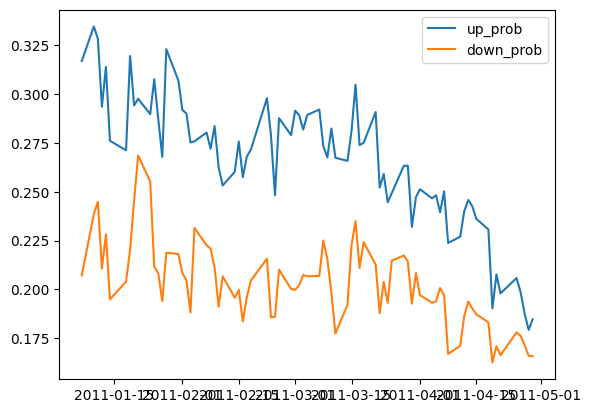

In [10]:
plt.plot(results['up_prob'], label = 'up_prob')
plt.plot(results['down_prob'], label = 'down_prob')
plt.legend()
plt.show()

In [11]:
results

,^IRX,^SPX,up_prob,down_prob,skewness,kurtosis,mean,variance,median,p10,p90
Date,,,,,,,,,,,
2011-01-07,0.135,1271.500000,0.3169,0.2072,1.0858,-0.3065,1270.7929,41522.7438,1318,1018,1529
2011-01-10,0.135,1269.750000,0.3346,0.2386,1.6923,1.4680,1374.2099,122425.1209,1292,999,1550
2011-01-11,0.145,1274.479980,0.3283,0.2448,1.6224,1.2034,1273.0806,53592.7590,1312,969,1539
2011-01-12,0.145,1285.959961,0.2935,0.2107,1.7602,1.7079,1409.5604,123446.8960,1301,1054,1515
2011-01-13,0.140,1283.760010,0.3139,0.2282,1.6123,1.1800,1402.6875,126110.2812,1300,1032,1541
...,...,...,...,...,...,...,...,...,...,...,...
2011-04-25,0.045,1335.250000,0.2058,0.1780,1.9584,2.4759,1338.7664,29235.0753,1350,1132,1530
2011-04-26,0.055,1347.239990,0.1986,0.1763,1.8947,2.2116,1349.6964,27971.9558,1359,1147,1542
2011-04-27,0.050,1355.660034,0.1877,0.1716,1.9299,2.3522,1358.1052,26639.6868,1366,1160,1545


In [12]:
for f in csv_files:
    print(f)
    csvfile_, df_ = load_csv(f)
    if csvfile_['Expiration'][0] == csvfile['Expiration'][0]:
        continue
    else:
        df_ = date_strike(csvfile_, df_)
        df_window_ = get_nwindow(df_, n)
        df_iv_ = get_iv(df_window_, csvfile_, n)
        results_ = get_prob(df_iv_, csvfile_, n, 0.1)
        results = pd.concat([results, results_], axis=0)

results

Orgnized Data\101.csv
[*********************100%%**********************]  2 of 2 completed
Orgnized Data\102.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\103.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


[*********************100%%**********************]  2 of 2 completed
Orgnized Data\104.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\105.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\106.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\107.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\108.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\109.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\110.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\111.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\112.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\113.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\114.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\115.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: overflow encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: Runtim

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\116.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\117.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\118.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\119.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\120.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\121.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\122.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\123.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\124.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\125.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\126.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\127.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\128.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\129.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\130.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\131.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\132.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed
Orgnized Data\133.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\134.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\135.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\136.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\137.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\138.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed
Orgnized Data\139.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


Orgnized Data\140.csv
[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  sigma -= diff / vega(S, K, T, r, sigma)
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:47: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\84903\AppData\Local\Temp\ipykernel_1

[*********************100%%**********************]  2 of 2 completed


C:\Users\84903\AppData\Local\Temp\ipykernel_16252\4009778277.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


,^IRX,^SPX,up_prob,down_prob,skewness,kurtosis,mean,variance,median,p10,p90
Date,,,,,,,,,,,
2011-01-07,0.135,1271.500000,0.3169,0.2072,1.0858,-0.3065,1270.7929,41522.7438,1318,1018,1529
2011-01-10,0.135,1269.750000,0.3346,0.2386,1.6923,1.4680,1374.2099,122425.1209,1292,999,1550
2011-01-11,0.145,1274.479980,0.3283,0.2448,1.6224,1.2034,1273.0806,53592.7590,1312,969,1539
2011-01-12,0.145,1285.959961,0.2935,0.2107,1.7602,1.7079,1409.5604,123446.8960,1301,1054,1515
2011-01-13,0.140,1283.760010,0.3139,0.2282,1.6123,1.1800,1402.6875,126110.2812,1300,1032,1541
...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,0.070,3855.360107,0.2784,0.1905,1.6098,1.2175,3853.3838,370479.6495,4001,3106,4451
2021-01-26,0.068,3849.620117,0.2814,0.1883,1.4036,0.5250,3847.3655,311757.0274,3983,3158,4511
2021-01-27,0.060,3750.770020,0.3490,0.1511,1.5482,1.0250,3883.0176,249330.5602,3965,3178,4393


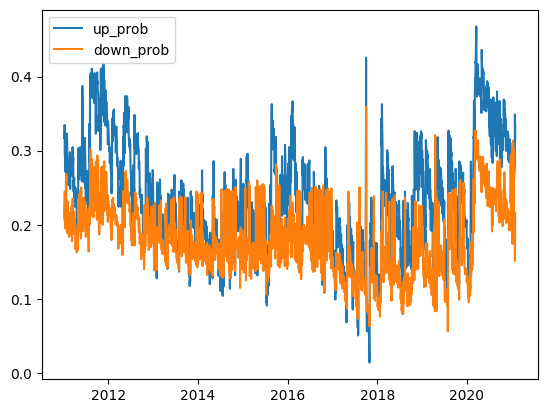

In [13]:
plt.plot(results['up_prob'], label = 'up_prob')
plt.plot(results['down_prob'], label = 'down_prob')
plt.legend()
plt.show()

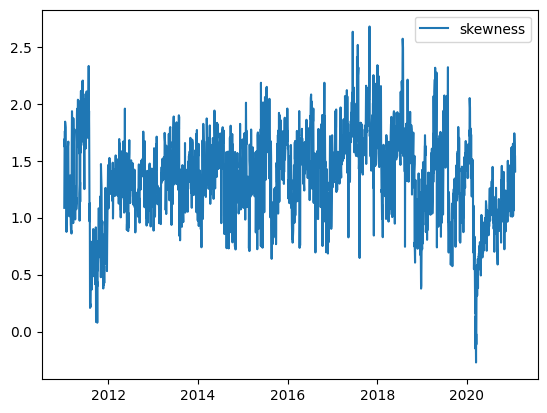

In [14]:
plt.plot(results['skewness'], label = 'skewness')
plt.legend()
plt.show()

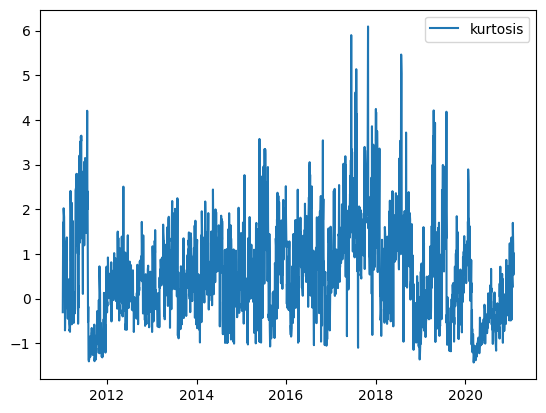

In [15]:
plt.plot(results['kurtosis'], label = 'kurtosis')
plt.legend()
plt.show()

In [16]:
results.to_csv('results.csv', index = True)